Checking out what GPU we got:

In [1]:
!nvidia-smi

Thu Jun 16 08:34:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

First we clone the git repo:

In [2]:
%%shell
git clone https://github.com/BouazzaSE/TorchCSD.git

Cloning into 'TorchCSD'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 217 (delta 81), reused 160 (delta 47), pack-reused 0
Receiving objects: 100% (217/217), 112.43 KiB | 10.22 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [3]:
# %%shell
# cd TorchCSD
# git pull origin

We then download the libtorch library. For this build example we download the 1.11 version targetted at a CUDA toolkit with version 10.2 (the library should work if the installed toolkit is more recent):

In [4]:
%%shell
wget https://download.pytorch.org/libtorch/cu102/libtorch-cxx11-abi-shared-with-deps-1.11.0%2Bcu102.zip
unzip -q libtorch-cxx11-abi-shared-with-deps-1.11.0+cu102.zip

--2022-06-16 08:35:03--  https://download.pytorch.org/libtorch/cu102/libtorch-cxx11-abi-shared-with-deps-1.11.0%2Bcu102.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.208.88, 13.32.208.46, 13.32.208.73, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.208.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813658822 (776M) [application/zip]
Saving to: ‘libtorch-cxx11-abi-shared-with-deps-1.11.0+cu102.zip’

libtorch-cxx11-abi- 100%[===================>] 775.96M  28.7MB/s    in 22s     

2022-06-16 08:35:25 (35.3 MB/s) - ‘libtorch-cxx11-abi-shared-with-deps-1.11.0+cu102.zip’ saved [813658822/813658822]



Specific libtorch CMake files are needed so that our project knows how to link against libtorch. These are found inside `libtorch/share/cmake/Torch`:

In [5]:
%%shell
ls libtorch/share/cmake/Torch

TorchConfig.cmake  TorchConfigVersion.cmake


Now we simply build our project using CMake:

In [6]:
%%shell
cd TorchCSD
# rm -rf build
mkdir build
cd build
CC=clang CXX=clang++ cmake -DCMAKE_PREFIX_PATH=/content/libtorch/share/cmake/Torch ..
CC=clang CXX=clang++ cmake --build . --config Release

-- The CUDA compiler identification is NVIDIA 11.1.105
-- The CXX compiler identification is Clang 6.0.0
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/clang++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for C++ include pthread.h
-- Looking for C++ include pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "11.1") 
-- Caffe2: 

The following will launch a training using our training example code. In particular it will use 8388608 samples (half of which are used for training, the other half being used as validation to select the best iterate during the training), 32 sub samples which are averaged over in order to reduce a little bit the variance without necessarily targetting prices, 6 hidden layers and `2*(3+5*5)` neurons per hidden layer.

It will train for 300 epochs after warming-up (*ie* training without derivatives in order to get a good initial point) for 30 epochs. The batch size for training is 16384 and for validation 32768. The learning rate during training is 0.01 while during the warm-up phase it is 0.005. We include all the errors (in this order: call and put payoff projection errors and call and put payoff derivatives projection errors) and the no-arbitrage lower-bound penalization term by putting weights 1 in front of them. Finally we halve the learning rate every 50 epochs.

See `demos/train_vanilla_locvol.cpp` and `lib/training/training.cpp` for further details.

In [7]:
%%shell
cd TorchCSD/build/demos
./train_vanilla_locvol 0 1 0 8388608 32 6 2 300 30 16384 32768 0.01 0.005 1 1 1 1 1 50 my_neural_net.pt

my_neural_net.pt
Generated 8388608 instances of model parameters in 0.0205 seconds
Generated 8388608 labels in 241.4292 seconds
[INIT] 16.0103
[WARMUP][e = 0] 0.8751
[WARMUP][e = 5] 0.8725
[WARMUP][e = 10] 0.8721
[WARMUP][e = 15] 0.8717
[WARMUP][e = 20] 0.8715
[WARMUP][e = 25] 0.8713
[TRAIN][e = 0] 1.9436|1.9436
[TRAIN][e = 5] 1.7425|1.7425
[TRAIN][e = 10] 1.7681|1.7425
[TRAIN][e = 15] 1.8423|1.7425
[TRAIN][e = 20] 1.9395|1.7425
[TRAIN][e = 25] 1.8646|1.7425
[TRAIN][e = 30] 1.7779|1.7425
[TRAIN][e = 35] 1.7399|1.7399
[TRAIN][e = 40] 1.9314|1.7399
[TRAIN][e = 45] 1.9177|1.7399
[TRAIN][e = 50] 1.7319|1.7319
[TRAIN][e = 55] 1.7661|1.7319
[TRAIN][e = 60] 1.9522|1.7319
[TRAIN][e = 65] 1.9562|1.7319
[TRAIN][e = 70] 1.8087|1.7319
[TRAIN][e = 75] 1.8876|1.7319
[TRAIN][e = 80] 1.8715|1.7319
[TRAIN][e = 85] 1.9631|1.7319
[TRAIN][e = 90] 1.7728|1.7319
[TRAIN][e = 95] 1.9272|1.7319
[TRAIN][e = 100] 1.8964|1.7319
[TRAIN][e = 105] 1.7812|1.7319
[TRAIN][e = 110] 1.9156|1.7319
[TRAIN][e = 115] 1.8483|

Now we want to compute some prices and gradients using the neural network we just trained.

In [8]:
%%shell
cd TorchCSD/build/demos
./price_vanilla_locvol 0 6 56 my_neural_net.pt prices.pt grads.pt

my_neural_net.pt
Computed 1024 prices and gradients (28 partial derivatives) in 5.0648 milliseconds


Let's benchmark those approximated prices against a (slow) reference nested Monte Carlo pricer. The pricer here is in CUDA but for simplicity is written in Python and we are using Numba to write a CUDA kernel from within Python.

In [9]:
import math
import matplotlib.pyplot as plt
from numba import cuda
import numba as nb
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32, xoroshiro128p_normal_float32, xoroshiro128p_type
import numpy as np
import torch

First let's load the files containing the computed prices and gradients and check that the dump did indeed work.

In [10]:
prices = next(torch.load('TorchCSD/build/demos/prices.pt', map_location=torch.device('cpu')).parameters())
grads = next(torch.load('TorchCSD/build/demos/grads.pt', map_location=torch.device('cpu')).parameters())

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


In [11]:
prices.shape

torch.Size([1024, 1])

In [12]:
grads.shape

torch.Size([1024, 28])

Shapes look alright. Now what follows is our implementation of a Monte Carlo pricer using the same model parameters.

**WARNING:** The following can take very long on the weak GPU instances that are available for free on Google Colaboratory.

In [13]:
num_prices = 128 # less than the prices computed using the neural network, because the MC is much slower
num_nodes_x = 5
num_nodes_y = 5
num_inputs = 3+num_nodes_x*num_nodes_y
nodes_x = np.linspace(1./12, 2., num_nodes_x, dtype=np.float32)
nodes_y = np.linspace(math.log(0.25), math.log(2.1), num_nodes_y, dtype=np.float32)

X_test = torch.empty(num_prices, num_inputs, dtype=torch.float32, device='cuda:0')
X_test[:, 0] = 0.0128 # r
X_test[:, 1] = torch.linspace(0.5, 2., num_prices) # K
X_test[:, 2] = 1. # T
X_test[:, 3:] = torch.as_tensor(
    [
        [1.8182, 0.8224, 0.7496, 0.4949, 1.0417],
        [1.3432, 0.9347, 0.5703, 0.4868, 0.6863],
        [1.8182, 0.3757, 0.5789, 0.5348, 0.6655],
        [0.8435, 0.1100, 0.8001, 0.7003, 0.2425],
        [1.8182, 1.1904, 0.6852, 0.1100, 1.1492]
    ]
).view(1, num_nodes_x*num_nodes_y)

In [14]:
ntpb_price = 1024
num_samples_price = 2**18

@cuda.jit(device=True, inline=True)
def _binary_search(x, arr, low, high):
    while True:
        mid = (high+low)//2
        if mid == low:
            return mid
        if x < arr[mid]:
            high = mid
        elif x > arr[mid]:
            low = mid
        else:
            return mid

signature = (xoroshiro128p_type[:], nb.float32, nb.float32, nb.float32[:], nb.float32, nb.float32[:, :], nb.float32[:], nb.float32[:, :], nb.float32[:], nb.float32[:], nb.float32[:, :], nb.float32[:], nb.int32)
@cuda.jit(func_or_sig=signature, max_registers=64)
def _batch_call_price(rng_states, S0, r, K_arr, T, lv_arr, price, dprice, dpricedTdiff, price_std, dprice_std, dpricedTdiff_std, num_steps_per_year):
    pricing_idx = cuda.blockIdx.x
    local_path_idx = cuda.threadIdx.x
    dS = cuda.local.array(num_inputs, dtype=nb.float32)
    dpayoff = cuda.local.array(num_inputs, dtype=nb.float32)
    dpayoff_sq = cuda.local.array(num_inputs, dtype=nb.float32)
    sh_arr = cuda.shared.array(ntpb_price, dtype=nb.float32)
    lv = cuda.local.array((num_nodes_x, num_nodes_y), dtype=nb.float32)
    local_rng_state = cuda.local.array(1, dtype=xoroshiro128p_type)
    cst_nodes_x = cuda.const.array_like(nodes_x)
    cst_nodes_y = cuda.const.array_like(nodes_y)
    for i in range(num_nodes_x):
        for j in range(num_nodes_y):
            lv[i, j] = lv_arr[i, j]
    K = K_arr[pricing_idx]
    num_steps = int(T*num_steps_per_year+0.1)
    dt = 1/num_steps_per_year
    sqrt_dt = math.sqrt(dt)
    T = num_steps*dt
    df = math.exp(-r*T)
    df_prev = math.exp(-r*(num_steps-1)*dt)
    # sh_payoff[local_path_idx] = 0
    # sh_payoff_sq[local_path_idx] = 0
    # for i in range(num_inputs):
    #     sh_dpayoff[local_path_idx, i] = 0
    #     sh_dpayoff_sq[local_path_idx, i] = 0
    # sh_dpayoffdTdiff[local_path_idx] = 0
    # sh_dpayoffdTdiff_sq[local_path_idx] = 0
    payoff = 0
    payoff_sq = 0
    dpayoffdTdiff = 0
    dpayoffdTdiff_sq = 0
    for i in range(num_inputs):
        dpayoff[i] = 0
        dpayoff_sq[i] = 0
    local_rng_state[0]['s0'] = rng_states[local_path_idx]['s0']
    local_rng_state[0]['s1'] = rng_states[local_path_idx]['s1']
    for n in range((num_samples_price+ntpb_price-1)//ntpb_price):
        # ASSUMING THAT num_samples IS A MULTIPLE OF ntpb
        S = math.log(S0)
        for i in range(num_inputs):
            dS[i] = 0
        t = 0
        _k = 0
        for i in range(num_steps):
            Z = xoroshiro128p_normal_float32(local_rng_state, 0)
            _k = _binary_search(t, cst_nodes_x, _k, num_nodes_x)
            _l = _binary_search(S, cst_nodes_y, 0, num_nodes_y)
            if (cst_nodes_x[0] <= t < cst_nodes_x[num_nodes_x-1]) and (cst_nodes_y[0] <= S < cst_nodes_y[num_nodes_y-1]):
                # alien way of computing things efficiently :-)
                _delta = lv[_k+1, _l]-lv[_k, _l]
                _dx = cst_nodes_x[_k+1]-cst_nodes_x[_k]
                _lv = _delta*(t-cst_nodes_x[_k])/_dx+lv[_k, _l]
                # d/dT
                _dlv = i*_delta/_dx # i*(lv[_k+1, _l]-lv[_k, _l])/_dx
                _delta = lv[_k+1, _l+1]-lv[_k, _l+1]-_delta # lv[_k+1, _l+1]-lv[_k, _l+1]-lv[_k+1, _l]+lv[_k, _l]
                _dy = cst_nodes_y[_l+1]-cst_nodes_y[_l]
                _dlv += i*_delta*(S-cst_nodes_y[_l])/(_dx*_dy) # i*(lv[_k+1, _l]-lv[_k, _l])/_dx+
                _delta *= (t-cst_nodes_x[_k])/_dx
                _delta += lv[_k, _l+1]-lv[_k, _l]
                _delta /= _dy
                _dlv += dS[2]*_delta
                _lv += (S-cst_nodes_y[_l])*_delta
                dS[2] += r-0.5*_lv**2-_lv*_dlv*dt+_dlv*sqrt_dt*Z+0.5*_lv*Z/sqrt_dt
                # d/dr
                _dlv = dS[0]*_delta
                dS[0] += dt-_lv*_dlv*dt+_dlv*sqrt_dt*Z
                # d/dlv
                _dlv = dS[3+_k*num_nodes_y+_l]*_delta+(cst_nodes_y[_l+1]-S)*(cst_nodes_x[_k+1]-t)/(_dx*_dy)
                dS[3+_k*num_nodes_y+_l] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
                _dlv = dS[3+_k*num_nodes_y+_l+1]*_delta+(S-cst_nodes_y[_l])*(cst_nodes_x[_k+1]-t)/(_dx*_dy)
                dS[3+_k*num_nodes_y+_l+1] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
                _dlv = dS[3+(_k+1)*num_nodes_y+_l]*_delta+(cst_nodes_y[_l+1]-S)*(t-cst_nodes_x[_k])/(_dx*_dy)
                dS[3+(_k+1)*num_nodes_y+_l] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
                _dlv = dS[3+(_k+1)*num_nodes_y+_l+1]*_delta+(S-cst_nodes_y[_l])*(t-cst_nodes_x[_k])/(_dx*_dy)
                dS[3+(_k+1)*num_nodes_y+_l+1] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
            elif cst_nodes_y[0] <= S < cst_nodes_y[num_nodes_y-1]:
                _dy = cst_nodes_y[_l+1]-cst_nodes_y[_l]
                _delta = (lv[_k, _l+1]-lv[_k, _l])/_dy
                _lv = lv[_k, _l]+_delta*(S-cst_nodes_y[_l])
                # d/dT
                _dlv = dS[2]*_delta
                dS[2] += r-0.5*_lv**2-_lv*_dlv*dt+_dlv*sqrt_dt*Z+0.5*_lv*Z/sqrt_dt
                # d/dr
                _dlv = dS[0]*_delta
                dS[0] += dt-_lv*_dlv*dt+_dlv*sqrt_dt*Z
                # d/dlv
                _dlv = dS[3+_k*num_nodes_y+_l]*_delta+(cst_nodes_y[_l+1]-S)/_dy
                dS[3+_k*num_nodes_y+_l] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
                _dlv = dS[3+_k*num_nodes_y+_l+1]*_delta+(S-cst_nodes_y[_l])/_dy
                dS[3+_k*num_nodes_y+_l+1] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
            elif cst_nodes_x[0] <= t < cst_nodes_x[num_nodes_x-1]:
                _dx = cst_nodes_x[_k+1]-cst_nodes_x[_k]
                _delta = (lv[_k+1, _l]-lv[_k, _l])/_dx
                _lv = lv[_k, _l]+_delta*(t-cst_nodes_x[_k])
                # d/dT
                _dlv = i*_delta
                dS[2] += r-0.5*_lv**2-_lv*_dlv*dt+_dlv*sqrt_dt*Z+0.5*_lv*Z/sqrt_dt
                # d/dr
                dS[0] += dt
                # d/dlv
                _dlv = (cst_nodes_x[_k+1]-t)/_dx
                dS[3+_k*num_nodes_y+_l] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
                _dlv = (t-cst_nodes_x[_k])/_dx
                dS[3+(_k+1)*num_nodes_y+_l] += -_lv*_dlv*dt+_dlv*sqrt_dt*Z
            else:
                _lv = lv[_k, _l]
                # d/dT
                dS[2] += r-0.5*_lv**2+0.5*_lv*Z/sqrt_dt
                # d/dr
                dS[0] += dt
                # d/dlv
                dS[3+_k*num_nodes_y+_l] += -_lv*dt+sqrt_dt*Z
            if i==num_steps-1:
                S_prev = math.exp(S)
            S += (r-0.5*_lv**2)*dt+_lv*sqrt_dt*Z
            t += dt
        S = math.exp(S)
        for i in range(num_inputs):
            dS[i] *= S
        dS[2] /= num_steps
        call_payoff = df*max(S-K, 0)
        payoff += call_payoff
        payoff_sq += call_payoff**2
        for i in range(num_inputs):
            _dpayoff = dS[i]*df if S>K else 0
            if i==0:
                _dpayoff -= T*call_payoff
            elif i==1:
                _dpayoff -= df if S>K else 0
            elif i==2:
                _dpayoff -= r*call_payoff
            dpayoff[i] += _dpayoff
            dpayoff_sq[i] += _dpayoff**2
        _dpayoffdTdiff = -r*call_payoff
        if S > K:
            _dpayoffdTdiff += df*r*S
        d1 = (math.log(K/S_prev)-(r-0.5*_lv*_lv)*dt)/(_lv*sqrt_dt)
        _dpayoffdTdiff += 0.5*df*_lv*_lv*S*S*math.exp(-0.5*d1*d1)/(math.sqrt(2*math.pi*dt)*_lv*K)
        dpayoffdTdiff += _dpayoffdTdiff
        dpayoffdTdiff_sq += _dpayoffdTdiff**2
    # price
    sh_arr[local_path_idx] = payoff
    cuda.syncthreads()
    k = ntpb_price // 2
    while k > 0:
        if local_path_idx < k:
            sh_arr[local_path_idx] += sh_arr[local_path_idx+k]
        cuda.syncthreads()
        k //= 2
    k = ntpb_price // 2
    if local_path_idx == 0:
        price[pricing_idx] = sh_arr[local_path_idx]/(ntpb_price*(n+1))
    # price std
    sh_arr[local_path_idx] = payoff_sq
    cuda.syncthreads()
    k = ntpb_price // 2
    while k > 0:
        if local_path_idx < k:
            sh_arr[local_path_idx] += sh_arr[local_path_idx+k]
        cuda.syncthreads()
        k //= 2
    k = ntpb_price // 2
    if local_path_idx == 0:
        price_std[pricing_idx] = math.sqrt((sh_arr[local_path_idx]/(ntpb_price*(n+1))-price[pricing_idx]**2)/(ntpb_price*(n+1)))
    # dprice & dprice_std
    for i in range(num_inputs):
        sh_arr[local_path_idx] = dpayoff[i]
        cuda.syncthreads()
        k = ntpb_price // 2
        while k > 0:
            if local_path_idx < k:
                sh_arr[local_path_idx] += sh_arr[local_path_idx+k]
            cuda.syncthreads()
            k //= 2
        k = ntpb_price // 2
        if local_path_idx == 0:
            dprice[pricing_idx, i] = sh_arr[local_path_idx]/(ntpb_price*(n+1))
        sh_arr[local_path_idx] = dpayoff_sq[i]
        cuda.syncthreads()
        k = ntpb_price // 2
        while k > 0:
            if local_path_idx < k:
                sh_arr[local_path_idx] += sh_arr[local_path_idx+k]
            cuda.syncthreads()
            k //= 2
        k = ntpb_price // 2
        if local_path_idx == 0:
            dprice_std[pricing_idx, i] = math.sqrt((sh_arr[local_path_idx]/(ntpb_price*(n+1))-dprice[pricing_idx, i]**2)/(ntpb_price*(n+1)))
    # dpricedTdiff
    sh_arr[local_path_idx] = dpayoffdTdiff
    cuda.syncthreads()
    k = ntpb_price // 2
    while k > 0:
        if local_path_idx < k:
            sh_arr[local_path_idx] += sh_arr[local_path_idx+k]
        cuda.syncthreads()
        k //= 2
    k = ntpb_price // 2
    if local_path_idx == 0:
        dpricedTdiff[pricing_idx] = sh_arr[local_path_idx]/(ntpb_price*(n+1))
    # dpricedTdiff std
    sh_arr[local_path_idx] = dpayoffdTdiff_sq
    cuda.syncthreads()
    k = ntpb_price // 2
    while k > 0:
        if local_path_idx < k:
            sh_arr[local_path_idx] += sh_arr[local_path_idx+k]
        cuda.syncthreads()
        k //= 2
    k = ntpb_price // 2
    if local_path_idx == 0:
        dpricedTdiff_std[pricing_idx] = math.sqrt((sh_arr[local_path_idx]/(ntpb_price*(n+1))-dpricedTdiff[pricing_idx]**2)/(ntpb_price*(n+1)))
batch_call_price = _batch_call_price[num_prices, ntpb_price]

In [ ]:
num_steps_per_year = 1000

nb_evt_start = cuda.event(timing=True)
nb_evt_stop = cuda.event(timing=True)

rng_states = create_xoroshiro128p_states(ntpb_price, 0)

mc_price = cuda.device_array(num_prices, dtype=np.float32)
mc_price_std = cuda.device_array(num_prices, dtype=np.float32)
mc_dprice = cuda.device_array((num_prices, num_inputs), dtype=np.float32)
mc_dprice_std = cuda.device_array((num_prices, num_inputs), dtype=np.float32)
mc_dpricedTdiff = cuda.device_array(num_prices, dtype=np.float32)
mc_dpricedTdiff_std = cuda.device_array(num_prices, dtype=np.float32)

nb_evt_start.record()
batch_call_price(rng_states, 1., X_test[0, 0], cuda.as_cuda_array(X_test[:, 1]), X_test[0, 2], cuda.as_cuda_array(X_test[0, 3:].reshape(num_nodes_x, num_nodes_y)), mc_price, mc_dprice, mc_dpricedTdiff, mc_price_std, mc_dprice_std, mc_dpricedTdiff_std, num_steps_per_year)
nb_evt_stop.record()
nb_evt_stop.synchronize()

print('Elapsed time: {} secs'.format(round(nb_evt_start.elapsed_time(nb_evt_stop)/1000, 3)))

In [16]:
_price_NN = prices.numpy()[:, 0]
_grads_NN = grads.numpy()

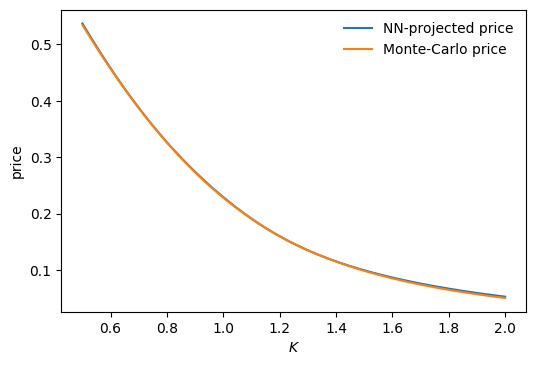

In [18]:
plt.figure(dpi=100)
with torch.no_grad():
    _price_MC = mc_price.copy_to_host()
    plt.plot(np.linspace(0.5, 2., 1024), _price_NN, label='NN-projected price')
    plt.plot(X_test[:, 1].cpu().numpy(), _price_MC, label='Monte-Carlo price')
    plt.xlabel(r'$K$')
    plt.ylabel('price')
    plt.legend(frameon=False);

In [19]:
_dprice_MC = mc_dprice.copy_to_host()

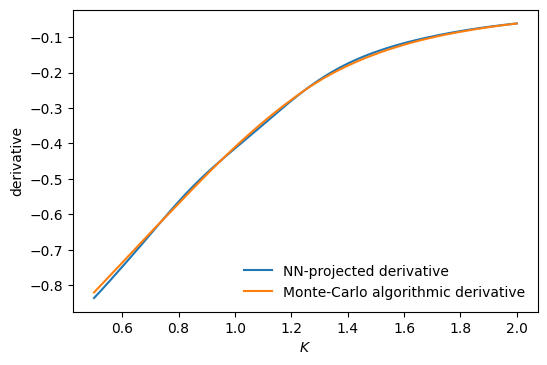

In [22]:
var_diff_idx = 1 # index of the variable with respect to which we want the derivative
# 1 corresponds to the strike in this example
plt.figure(dpi=100)
with torch.no_grad():
    plt.plot(np.linspace(0.5, 2., 1024), _grads_NN[:, var_diff_idx], label='NN-projected derivative')
    plt.plot(X_test[:, 1].cpu().numpy(), _dprice_MC[:, var_diff_idx], label='Monte-Carlo algorithmic derivative')
    plt.xlabel(r'$K$')
    plt.ylabel('derivative')
    plt.legend(frameon=False);